**Warning**: Long execution time of the notebook because of computationally expensive model training. 

Paths need to be adapted.

Data loading and training is based on distributed computing on TPUs. Code that implements the parallelization needs to be commented with '#' so that in can be executed in an environment without access to TPUs.

In [1]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 464 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np 
import pandas as pd 
import re
import gc 
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB5 as Net
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.utils import class_weight

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import Concatenate, Input, concatenate
from keras import Model

In [3]:
# initialize the TPU accelerator
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('running on', tpu.master())
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

running on grpc://10.0.0.2:8470


In [4]:
def decode_image(image_data):
    """convert image to floats in [0,1] range and reshape"""
    
    image = tf.image.decode_jpeg(image_data)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*image_size, 3]) 

    return image

def read_labeled_tfrecord(example):
    """define TF record format for labeled train and validation set"""
    
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        'age_approx': tf.io.FixedLenFeature([], tf.float32),
        'female': tf.io.FixedLenFeature([], tf.int64),
        'male': tf.io.FixedLenFeature([], tf.int64),
        'head_neck': tf.io.FixedLenFeature([], tf.int64),
        'lower_extremity': tf.io.FixedLenFeature([], tf.int64),
        'missing': tf.io.FixedLenFeature([], tf.int64),
        'oral_genital': tf.io.FixedLenFeature([], tf.int64),
        'palms_soles': tf.io.FixedLenFeature([], tf.int64),
        'torso': tf.io.FixedLenFeature([], tf.int64),
        'upper_extremity': tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64), 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    data = {}
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['female'] = tf.cast(example['female'], tf.int32)
    data['male'] = tf.cast(example['male'], tf.int32)
    data['head_neck'] = tf.cast(example['head_neck'], tf.int32)
    data['lower_extremity'] = tf.cast(example['lower_extremity'], tf.int32)
    data['missing'] = tf.cast(example['missing'], tf.int32)
    data['oral_genital'] = tf.cast(example['oral_genital'], tf.int32)
    data['palms_soles'] = tf.cast(example['palms_soles'], tf.int32)
    data['torso'] = tf.cast(example['torso'], tf.int32)
    data['upper_extremity'] = tf.cast(example['upper_extremity'], tf.int32)
    return image, label, data # returns a dataset of (image, label, data) triples


def read_unlabeled_tfrecord(example):
    """define TF record format for unlabeled test set"""
    
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),  
        'age_approx': tf.io.FixedLenFeature([], tf.float32),
        'female': tf.io.FixedLenFeature([], tf.int64),
        'male': tf.io.FixedLenFeature([], tf.int64),
        'head_neck': tf.io.FixedLenFeature([], tf.int64),
        'lower_extremity': tf.io.FixedLenFeature([], tf.int64),
        'missing': tf.io.FixedLenFeature([], tf.int64),
        'oral_genital': tf.io.FixedLenFeature([], tf.int64),
        'palms_soles': tf.io.FixedLenFeature([], tf.int64),
        'torso': tf.io.FixedLenFeature([], tf.int64),
        'upper_extremity': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    data = {}
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['female'] = tf.cast(example['female'], tf.int32)
    data['male'] = tf.cast(example['male'], tf.int32)
    data['head_neck'] = tf.cast(example['head_neck'], tf.int32)
    data['lower_extremity'] = tf.cast(example['lower_extremity'], tf.int32)
    data['missing'] = tf.cast(example['missing'], tf.int32)
    data['oral_genital'] = tf.cast(example['oral_genital'], tf.int32)
    data['palms_soles'] = tf.cast(example['palms_soles'], tf.int32)
    data['torso'] = tf.cast(example['torso'], tf.int32)
    data['upper_extremity'] = tf.cast(example['upper_extremity'], tf.int32)
    return image, idnum, data

def count_data_items(filenames):
    """helper function to count the number of data items written in the name of the .tfrec files"""
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


def setup_input1(image, label, data):
    "define meta data to be merged with images later on for train/val set"
    meta_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'female', 'male', 'head_neck',
                                                                       'lower_extremity', 'missing', 'oral_genital',
                                                                       'palms_soles', 'torso', 'upper_extremity']]
    
    tabular = tf.stack(meta_data)
    
    return {'inp1': image, 'inp2':  tabular}, label


def setup_input2(image, image_name, data):
    "define meta data to be merged with images later on for test set"
    
    meta_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in ['age_approx', 'female', 'male', 'head_neck',
                                                                       'lower_extremity', 'missing', 'oral_genital',
                                                                       'palms_soles', 'torso', 'upper_extremity']]
    
    tabular = tf.stack(meta_data)
    
    return {'inp1': image, 'inp2':  tabular}, image_name

def data_augmentation(data, label):
    """image augmentation function applying different random augmentations to given image"""
    
    data['inp1'] = tf.image.random_flip_left_right(data['inp1']) #flipping
    data['inp1'] = tf.image.random_flip_up_down(data['inp1']) #flipping
    data['inp1'] = tf.image.random_hue(data['inp1'], 0.01) #change hue in a certain range
    data['inp1'] = tf.image.random_saturation(data['inp1'], 0.8, 1.2) #change saturation in a certain range
    data['inp1'] = tf.image.random_contrast(data['inp1'], 0.9, 1.1) #change contrast in a certain range
    data['inp1'] = tf.image.random_brightness(data['inp1'], 0.1) #change brightness in a certain range 
    
    return data, label

In [5]:
# read in data from google cloud storage
GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-tfrecords-with-metadata-256x256') 
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))


# configure basic parameters for model and images
EPOCHS = 8
batch_size = 8 * tpu_strategy.num_replicas_in_sync
image_size = [256, 256]
folds = 5
steps_per_epoch = count_data_items(files_train) // batch_size

# enable parallel streaming from multiple TFRecord files
AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False


#define different functions to define train/validation/test data
def get_dataset(filenames, labeled = True):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    if labeled == True:
        dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_training_dataset():
    dataset = get_dataset(files_train, labeled = True)
    dataset = dataset.map(setup_input1, num_parallel_calls = AUTO) #map dataset to TF record format
    dataset = dataset.map(data_augmentation, num_parallel_calls = AUTO) #apply augmentations
    dataset = dataset.cache()
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.batch(batch_size) # take batch
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training 
    dataset = dataset.shuffle(2048) #shuffe dataset
    return dataset

def get_validation_dataset():
    dataset = get_dataset(files_val, labeled = True)
    dataset = dataset.map(setup_input1, num_parallel_calls = AUTO)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_test_dataset():
    dataset = get_dataset(files_test, labeled=False)
    dataset = dataset.map(setup_input2, num_parallel_calls = AUTO)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) 
    return dataset

train_data = get_training_dataset()

115515392/115515256 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Model)         (None, 8, 8, 2048)   28513520    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 10)]         0                                            
__________________________________________________________________________________________________
gap (GlobalMaxPooling2D)        (None, 2048)         0           efficientnet-b5[1][0]            
___________________________

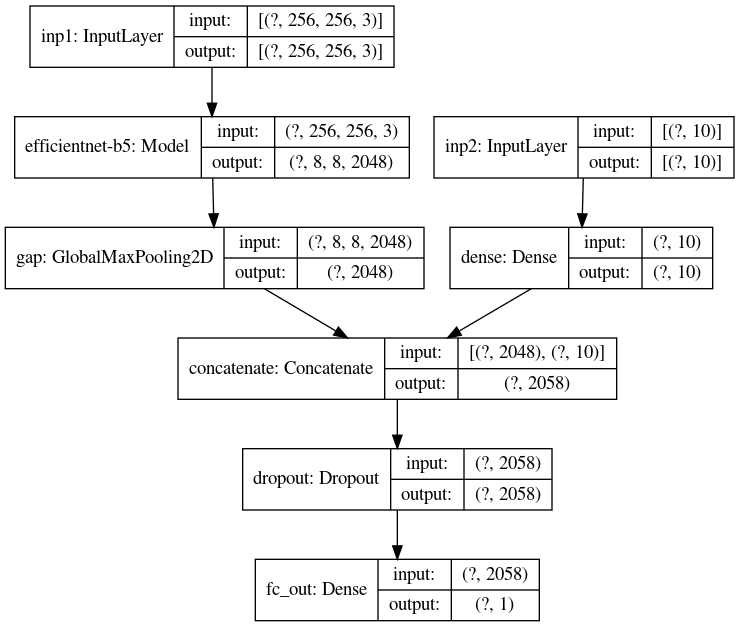

In [6]:
def get_model():
    "define EfficientNet B5 with transfer learning based on ImageNet"
    
    with tpu_strategy.scope():
        inp1 = Input(shape=(*image_size, 3), name='inp1') #image data
        conv_base = Net(weights="imagenet", include_top=False, input_shape=(*image_size, 3))(inp1)
        feature_extract = layers.GlobalMaxPooling2D(name="gap")(conv_base) #apply pooling

        inp2 = Input(shape=(10), name='inp2') #meta_data
        meta_features = tf.keras.layers.Dense(10)(inp2)
        merged_features = concatenate([feature_extract, meta_features]) #concatenate images with meta data
        merged_features = tf.keras.layers.Dropout(0.2)(merged_features) #apply dropout before last layer
        output = layers.Dense(1, activation="sigmoid", name="fc_out")(merged_features)

        conv_base.trainable = True # unfreeze convolutional base

        model = Model(inputs=[inp1,inp2], outputs = [output])


        opt = tf.keras.optimizers.Adam(learning_rate =3e-5)
        loss = tf.keras.losses.BinaryCrossentropy()
        model.compile(
            loss=loss,
            optimizer=opt,
            metrics=['AUC', 'accuracy'],
        )
    return model

model = get_model()
model.summary()

#visualize model architecture
tf.keras.utils.plot_model(model, to_file='model_viz.png', show_shapes=True)

In [7]:
#compute class weights because of imbalance problem
train_csv = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_csv = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

classes = np.unique(train_csv["target"].to_numpy())
classes_counts = train_csv["target"].to_numpy()
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes,
                                                 classes_counts)
class_weights = dict(enumerate(class_weights))
print("Class weights calculated by sklearn based on class distribution = ", class_weights)

Class weights calculated by sklearn based on class distribution =  {0: 0.5089730194825149, 1: 28.361301369863014}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [8]:
#define parameters for cross validation
kfold = KFold(folds, shuffle = True, random_state = 42)
n_tfrecords = 16

# collect metrics per epoch and fold here
histories = []
yhat = np.zeros((count_data_items(files_test),1))

#extract test data
files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
test_data = get_test_dataset()
test_data_img = test_data.map(lambda image, image_name: image)
test_data_name = test_data.map(lambda image, image_name: image_name).unbatch()
n_test = count_data_items(files_test)
test_data_name = next(iter(test_data_name.batch(n_test))).numpy().astype('U') # all in one batch

#train and cross validate the model
for fold, indices in enumerate(kfold.split(np.arange(n_tfrecords))):
    print('############')
    print('Starting new fold:', fold)
    
    train_indices = indices[0]
    val_indices = indices[1]
    
    files_train = tf.io.gfile.glob([GCS_PATH+ '/train%.2i*.tfrec'%x for x in train_indices])
    files_val = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in val_indices])
    
    train_data = get_training_dataset()
    val_data = get_validation_dataset()
    
    model = get_model()
    
    #define early stopping criterion and set learning rate scheduler
    #early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 3, 
    #                                                  verbose = 1, restore_best_weights = True)
    
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc', factor = 0.4, 
                                                          patience = 2, 
                                                          verbose = 1,
                                                          mode = 'max')
    #fit the model
    history = model.fit(train_data, 
                        validation_data=val_data,
                        epochs=EPOCHS, 
                        #callbacks=[early_stop,lr_schedule],
                        callbacks=[lr_schedule],
                        steps_per_epoch=steps_per_epoch,
                        class_weight = class_weights)
    
    histories.append(history)
    
    #predict test data and average predictions based on number of folds
    yhat_fold = model.predict(test_data_img)
    yhat += yhat_fold * 1 / folds
    
    # beware of memory limit
    del model
    gc.collect()

############
Starting new fold: 0
Epoch 1/8
517/517 [==============================] - 101s 196ms/step - auc: 0.7130 - accuracy: 0.6390 - loss: 0.9615 - val_auc: 0.7550 - val_accuracy: 0.8484 - val_loss: 0.4098 - lr: 3.0000e-05
Epoch 2/8
517/517 [==============================] - 78s 151ms/step - auc: 0.8328 - accuracy: 0.7473 - loss: 0.6639 - val_auc: 0.7882 - val_accuracy: 0.8069 - val_loss: 0.4743 - lr: 3.0000e-05
Epoch 3/8
517/517 [==============================] - 79s 154ms/step - auc: 0.9351 - accuracy: 0.8516 - loss: 0.3464 - val_auc: 0.8095 - val_accuracy: 0.8701 - val_loss: 0.3235 - lr: 3.0000e-05
Epoch 4/8
517/517 [==============================] - 80s 154ms/step - auc: 0.9590 - accuracy: 0.8824 - loss: 0.2780 - val_auc: 0.7907 - val_accuracy: 0.9218 - val_loss: 0.2090 - lr: 3.0000e-05
Epoch 5/8
517/517 [==============================] - ETA: 0s - auc: 0.9741 - accuracy: 0.9074 - loss: 0.2092
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.1999999696854503e-05.
517

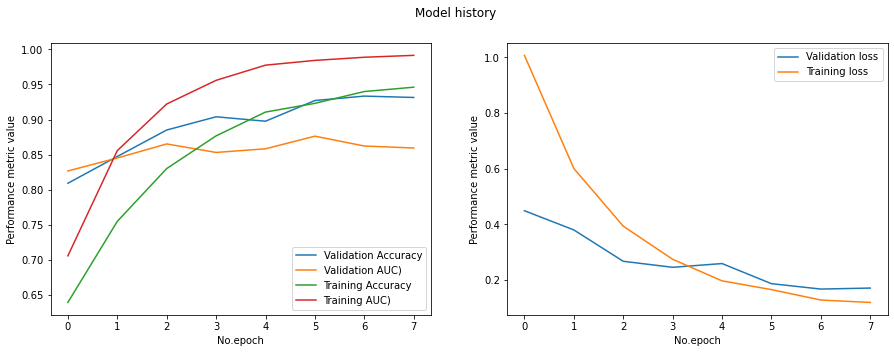

In [9]:
# averaging results over folds
avg_hist = {}
for key in histories[0].history.keys():
    avg_hist[key] = 0

for hist in histories:
    for metric in hist.history:
        avg_hist[metric] += np.array(hist.history[metric]) * 1 / folds
        
#plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (15,5))
fig.suptitle('Model history')

ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.plot(history.history['val_auc'], label='Validation AUC)')
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['auc'], label='Training AUC)')
ax1.set_xlabel("No.epoch")
ax1.set_ylabel('Performance metric value')
ax1.legend()

ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.plot(history.history['loss'], label='Training loss')
ax2.set_xlabel("No.epoch")
ax2.set_ylabel('Performance metric value')
ax2.legend()
plt.show()

In [10]:
yhat = yhat.flatten()
test_pred = pd.DataFrame({'image_name': test_data_name, 'target': yhat})

sub = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
sub.drop('target', inplace=True, axis=1)
sub = sub.merge(test_pred, on='image_name')
sub.to_csv('UKon_team_submission.csv', index=False)